In [1]:
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from numpy import array
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config=tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction=0.95
config.gpu_options.visible_device_list="2"
set_session(tf.Session(config=config))


/home/pushkarshukla/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Prepare text data

In [2]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text


In [3]:
# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 34
# print(tokenizer.word_index)


# Load Descriptions

In [4]:
# extract descriptions for images
def load_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
            
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # remove filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
        # store description
        mapping[image_id].append(image_desc)
    return mapping


# Clean description text

In [5]:
import string
 
def clean_descriptions(descriptions):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)

# clean descriptions
# clean_descriptions(descriptions)

In [6]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

# summarize vocabulary
# vocabulary = to_vocabulary(descriptions)
# print('Vocabulary Size of descriptions: %d' % len(vocabulary))

In [7]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

# save descriptions
# save_descriptions(descriptions, 'descriptions.txt')


In [8]:
token_description = 'Flickr8k_text/Flickr8k.token.txt' #file containing descriptions for each image in the Flicker dataset
# load descriptions
doc = load_doc(token_description)
# load descriptions
doc = load_doc(token_description)
print('number of descriptions for all the images:',len(doc)) #file which contains all the descriptions of the images
# parse descriptions
descriptions = load_descriptions(doc) 
print('Loaded: %d ' % len(descriptions))
# print(descriptions)
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size before cleaning: %d' % len(vocabulary))
# clean descriptions
clean_descriptions(descriptions)
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size after cleaning: %d' % len(vocabulary))
# save to file
save_descriptions(descriptions, 'descriptions.txt')

number of descriptions for all the images: 3395237
Loaded: 8092 
Vocabulary Size before cleaning: 9630
Vocabulary Size after cleaning: 8763


# Loading data

In [9]:
# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

In [10]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

In [11]:
# load photo features
def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features

In [12]:
# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

In [13]:
# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [14]:
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer


In [15]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, tokenizer, max_length):
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            # retrieve the photo feature
            photo = photos[key][0]
            in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo)
            yield [[in_img, in_seq], out_word]

In [16]:
# load training dataset 
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt' 
# Flickr_8k.trainImages.txt: predefined file that contains photo filenames used to extract the photo identifiers and these identifiers are used to filter photos and descriptions for each set.
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
td = len(train_descriptions)
print('td',td)
# photo features
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))


Dataset: 6000
Descriptions: train=6000
td 6000
Photos: train=6000


In [17]:
# prepare tokenizer
# from pickle import dump

# tokenizer = create_tokenizer(train_descriptions)
# vocab_size = len(tokenizer.word_index) + 1
# print('Vocabulary Size: %d' % vocab_size)
# # save the tokenizer
# dump(tokenizer, open('tokenizer.pkl', 'wb'))
# # print(tokenizer.word_index)

In [18]:
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
max_length = 25
# determine the maximum sequence length
# max_length = max_length(train_descriptions)
# print('Description Length: %d' % max_length)

Vocabulary Size: 7579


In [19]:
# prepare sequences
# X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features)


In [20]:
# define the captioning model
def define_model(vocab_size, max_length):
    # load the model
    
    model = load_model('model-ep_train003-loss3.016-val_loss3.336.h5')
    model.layers.pop()
    for layer in model.layers[:9]:
        layer.trainable = False
    
    output = model.get_layer('dense_2').output
    output = Dense(output_dim=vocab_size, activation='softmax', name = "dense_3")(output) # your newlayer Dense(...)
    new_model = Model(model.input, output)
    new_model.summary()
    new_model.compile(loss='categorical_crossentropy', optimizer='adam')
    
#     # feature extractor model
#     inputs1 = Input(shape=(4096,))
#     fe1 = Dropout(0.5)(inputs1)
#     fe2 = Dense(256, activation='relu')(fe1)
#     # sequence model
#     inputs2 = Input(shape=(max_length,))
#     se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
#     se2 = Dropout(0.5)(se1)
#     se3 = LSTM(256)(se2)
    # decoder model
#     decoder1 = add([fe2, se3])
#     decoder2 = Dense(256, activation='relu')(decoder1)
#     outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
#     model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    # compile model
    
#     # summarize model
    
#     model.summary()# Removing the last dense 3 layer
    

#     model.summary()
#     plot_model(model, to_file='model.png', show_shapes=True)

    return new_model

model2 = define_model(vocab_size, max_length)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 25)           0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 25, 256)      1273856     input_19[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_18[0][0]                   
__________________________________________________________________________________________________
dropout_2 

/home/pushkarshukla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", name="dense_3", units=7579)`
  # This is added back by InteractiveShellApp.init_path()


In [21]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [22]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

In [23]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        #print(desc_list[desc]);
        seq = tokenizer.texts_to_sequences(desc_list[desc])[0]
        #print (seq)
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(photo[desc][0])
            X2.append(in_seq)
            y.append(out_seq)
            #print(photo[desc])
    return array(X1), array(X2), array(y)
#print(tokenizer.word_index)
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features)
print(X1train)
# print(train_descriptions)
# print(train_features)

[[2.5076475 0.        0.        ... 0.        0.        0.       ]
 [2.5076475 0.        0.        ... 0.        0.        0.       ]
 [2.5076475 0.        0.        ... 0.        0.        0.       ]
 ...
 [2.3300757 0.        0.        ... 0.        2.7583213 0.       ]
 [2.3300757 0.        0.        ... 0.        2.7583213 0.       ]
 [2.3300757 0.        0.        ... 0.        2.7583213 0.       ]]


In [24]:
print(len(X1train[0]))

4096


In [25]:
# Fitting the model
# define checkpoint callback
# checkpoint = ModelCheckpoint(model2, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# checkpoint = ModelCheckpoint('./save_model-{epoch:02d}.hdf5', monitor='val_loss', verbose=1, save_best_only=False, mode='min')
# model2.fit([X1train, X2train], ytrain, epochs=20, verbose=1, callbacks=[checkpoint])

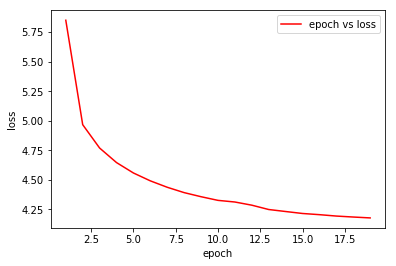

In [26]:
import numpy as np
import matplotlib.pyplot as plt

r = np.arange(1,20)
loss = np.array([5.8507,4.9670,4.7694,4.6463,4.5582,4.4916,4.4373,4.3920,4.3574,4.3265,4.3126,4.2858,4.2491,4.2322,4.2155,4.2055,4.1937,4.1855,4.1780])

plt.plot(r,loss,color='r',label='epoch vs loss')
# plt.plot(r,Loss,color='b',label='validation loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [27]:
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [28]:
# # prepare test set

# # load test set
# filename = 'Flickr8k_text/Flickr_8k.testImages.txt'
# test = load_set(filename)
# print('Dataset: %d' % len(test))
# # descriptions
# test_descriptions = load_clean_descriptions('descriptions.txt', test)
# print('Descriptions: test=%d' % len(test_descriptions))
# # photo features
# test_features = load_photo_features('features.pkl', test)
# print('Photos: test=%d' % len(test_features))

# # load the model
# #filename = 'model-ep002-loss3.245-val_loss3.612.h5'
# #model = load_model(filename)
# # evaluate model
# evaluate_model(model2, test_descriptions, test_features, tokenizer, max_length)

In [29]:
# load test set
from nltk.translate.bleu_score import corpus_bleu

filename = 'Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))
 
# load the model
filename = 'save_model-20.hdf5'
model = load_model(filename)
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

Dataset: 1000
Descriptions: test=1000
Photos: test=1000
BLEU-1: 0.516080
BLEU-2: 0.256203
BLEU-3: 0.166795
BLEU-4: 0.071425
